# Elise Hu: 2019 books

### Load Python tools 

In [1]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat

In [2]:
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [3]:
plt.rcParams['figure.figsize'] = (16,8)
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:,.2f}'.format
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
src = pd.read_excel('input/elise-2019-books.xlsx')

In [5]:
src.dtypes

Order                            int64
Title                           object
Author                          object
Pages                            int64
URL                             object
gender                          object
type                            object
Subgenre                        object
Avg GoodReads Rating           float64
Started                 datetime64[ns]
date                    datetime64[ns]
Faves                           object
dtype: object

In [6]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [7]:
src['year'] = src['date'].dt.year.astype(str).str.replace('.0','',regex=False)

In [8]:
src['type'] = src['type'].str.replace(' ', '-')

In [22]:
src['days_to_read'] = src['date'] - src['started']

In [23]:
src['gender_description'] = src.gender.replace({'M': 'Male', 'F': 'Female'})

In [40]:
src.dtypes

order                             int64
title                            object
author                           object
pages                             int64
url                              object
gender                           object
type                             object
subgenre                         object
avg_goodreads_rating            float64
started                  datetime64[ns]
date                     datetime64[ns]
faves                            object
year                             object
gender_description               object
days_to_read            timedelta64[ns]
dtype: object

In [44]:
src['days_to_read'] = src['days_to_read'].dt.days

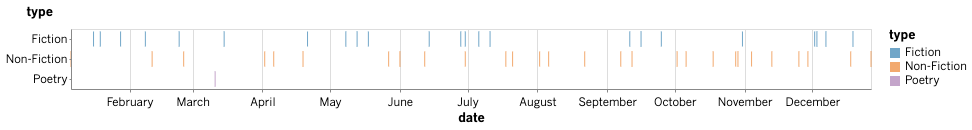

In [50]:
alt.Chart(src).mark_tick().encode(
    x='date',
    y='type',
    color='type'
)

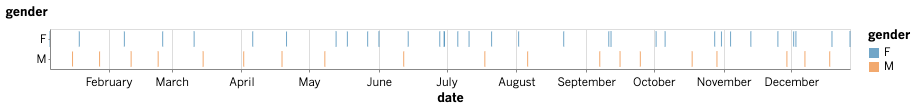

In [52]:
alt.Chart(src).mark_tick().encode(
    x='date',
    y='gender',
    color='gender'
)

In [24]:
books = pd.DataFrame(src)

---

In [25]:
books.head()

,order,title,author,pages,url,gender,type,subgenre,avg_goodreads_rating,started,date,faves,year,gender_description,days_to_read
0,1,Brotopia,Emily Chang,317,https://www.goodreads.com/book/show/36288143-b...,F,Non-Fiction,Business,4.04,2018-12-26,2019-01-06,NaN,2019,Female,11 days
1,2,The Human Stain,Philip Roth,384,https://www.goodreads.com/book/show/11734.The_...,M,Fiction,Literature,3.87,2019-01-06,2019-01-16,Y,2019,Male,10 days
2,3,You Know You Want This,Kristen Roupenian,225,https://www.goodreads.com/book/show/40539045-y...,F,Fiction,Short Stories,3.86,2019-01-16,2019-01-19,NaN,2019,Female,3 days
3,4,Why Buddhism is True,Robert Wright,336,https://www.goodreads.com/book/show/32895535-w...,M,Non-Fiction,Religion,4.05,2019-01-18,2019-04-02,NaN,2019,Male,74 days
4,5,If Beale Street Could Talk,James Baldwin,197,https://www.goodreads.com/book/show/38463.If_B...,M,Fiction,Classics,4.29,2019-01-22,2019-01-28,NaN,2019,Male,6 days


In [12]:
book_type = books.groupby(['type', 'year']).agg('size').reset_index(name='count').sort_values(by='count', ascending=False)
book_type.head()

,type,year,count
1,Non-Fiction,2019,28
0,Fiction,2019,23
2,Poetry,2019,1


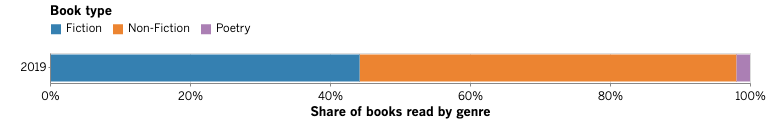

In [36]:
book_type_chart = alt.Chart(book_type).mark_bar().encode(
    x=alt.X('sum(count)', stack="normalize",  title='Share of books read by genre', \
            axis=alt.Axis(format='%',tickCount=6)),
    y=alt.Y('year',title=''),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'type',
      sort='ascending'
    ),
    color=alt.Color('type', legend=alt.Legend(orient="top", title='Book type'))
)

(book_type_chart).properties(height=30,width=700)

In [14]:
book_genre = books.groupby('subgenre').agg('size').reset_index(name='count')\
.sort_values(by='count', ascending=False)
book_genre.head()

,subgenre,count
2,Contemporary,10
10,Memoir,5
3,Essays,5
4,Feminism,5
7,History,4


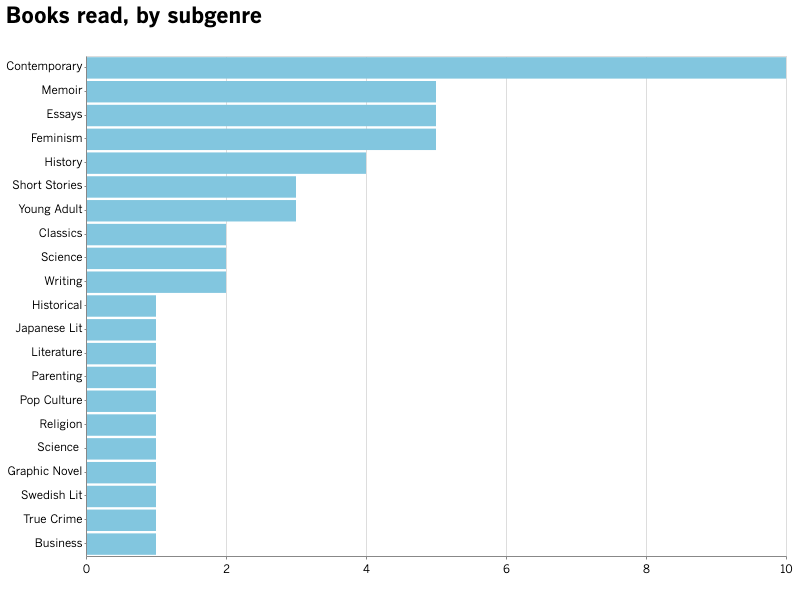

In [37]:
alt.Chart(book_genre).mark_bar().encode(
    y=alt.Y("subgenre:N", title=' ',
           sort=alt.EncodingSortField(
            field="count:Q",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in
        )),
    x=alt.X("count:Q", title=' ', axis=alt.Axis(tickCount=6, format=''))
).properties(height=500, width=700, title='Books read, by subgenre')

---

In [16]:
book_gender = books.groupby(['gender_description', 'year']).agg('size').reset_index(name='count').sort_values(by='count', ascending=False)
book_gender.head()

,gender_description,year,count
0,Female,2019,33
1,Male,2019,19


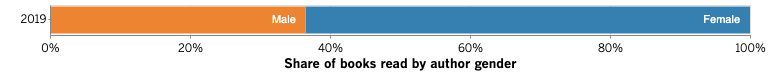

In [38]:
book_gender_chart = alt.Chart(book_gender).mark_bar().encode(
    x=alt.X('sum(count)', stack="normalize",  title='Share of books read by author gender',\
            axis=alt.Axis(format='%',tickCount=6)),
    y=alt.Y('year',title='',
            sort=alt.EncodingSortField(
            field="count:N",  # The field to use for the sort
            op="count",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in)
            )),
    color=alt.Color('gender_description', legend=None)
)

book_gender_chart_text = book_gender_chart.mark_text(
    align='right',
    baseline='middle',
    dx=-10
).encode(text=alt.Text('gender_description'), 
    color=alt.condition(
        alt.datum.year == '2019',
        alt.value('white'),
        alt.value('white')
    )
)


(book_gender_chart + book_gender_chart_text).properties(height=30,width=700)

---

### Ratings by subgenre

In [35]:
books.groupby(['subgenre', 'gender_description']).agg({ 'avg_goodreads_rating': 'mean' }).reset_index()\
.sort_values(by='avg_goodreads_rating',ascending=False)

,subgenre,gender_description,avg_goodreads_rating
21,True Crime,Male,4.48
23,Writing,Male,4.43
6,Graphic Novel,Female,4.30
16,Science,Male,4.29
13,Parenting,Female,4.26
1,Classics,Male,4.19
11,Memoir,Female,4.11
15,Religion,Male,4.05
0,Business,Female,4.04
22,Writing,Female,4.04
